0. Contexte

In [1]:
# Purpose
"""
Dataset name: MovieLens 'small'. This is a small dataset on films and user ratings.


Part 1 --> First objective: test a matrix factorisation model with Keras
-> Matrix factorisation is a technique for predicting film ratings by breaking down the large matrix (users × films) into two small matrices (one for users, one for films).
-> Basically, we learn 'vectors' that represent user preferences and film characteristics.


Part 2 --> Second objective: we make the model more complex
-> We add an MLP (Multilayer Perceptron) layer to the output.
-> Why? Because simple factorisation mainly learns linear (straight) relationships.
-> With an MLP, we can learn non-linear (more complex) relationships, which can improve predictions.
"""

"\nDataset name: MovieLens 'small'. This is a small dataset on films and user ratings.\n\n\nPart 1 --> First objective: test a matrix factorisation model with Keras\n-> Matrix factorisation is a technique for predicting film ratings by breaking down the large matrix (users × films) into two small matrices (one for users, one for films).\n-> Basically, we learn 'vectors' that represent user preferences and film characteristics.\n\n\nPart 2 --> Second objective: we make the model more complex\n-> We add an MLP (Multilayer Perceptron) layer to the output.\n-> Why? Because simple factorisation mainly learns linear (straight) relationships.\n-> With an MLP, we can learn non-linear (more complex) relationships, which can improve predictions.\n"

1. Setup configuration

In [2]:
# 1.1. Load requested libraries
import os 
import zipfile
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import ops


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras import layers  

In [3]:
# 1.2. working directory
HOME = os.getcwd()
HOME = os.path.dirname(HOME)
print(f"Current directory: {HOME}")

# Define parameters*
# * Embedding defaut size
EMBEDDING_SIZE = 50

Current directory: c:\Users\Visiteur\Desktop\Julien\Privacy\13-GitHub Projects\Recommendation Systeme


In [30]:
# 1.3. Load dataset
# * Unzip files
destination_path = os.path.join(HOME, "data", "raw")

archives = [
    os.path.join(HOME, "data", "raw", "smallmovieslens.zip"),
    os.path.join(HOME, "data", "raw", "movies.csv.zip"),
]

for archive in archives:
    with zipfile.ZipFile(archive, 'r') as zf:
        zf.extractall(destination_path)
    print(f"Extracted: {os.path.basename(archive)} → {destination_path}")

# * Load dataset

rating_data_path = os.path.join(HOME, 'data', 'raw', 'ratings.csv')
df = pd.read_csv(rating_data_path)

movie_data_path = os.path.join(HOME, 'data', 'raw', 'movies.csv')
movie_df = pd.read_csv(movie_data_path)

print("Display seven (7) random raws of the DataFrame:\n")
np.random.seed(0)
df.sample(7)


Extracted: smallmovieslens.zip → c:\Users\Visiteur\Desktop\Julien\Privacy\13-GitHub Projects\Recommendation Systeme\data\raw
Extracted: movies.csv.zip → c:\Users\Visiteur\Desktop\Julien\Privacy\13-GitHub Projects\Recommendation Systeme\data\raw
Display seven (7) random raws of the DataFrame:



,userId,movieId,rating,timestamp
41008,276,780,5.0,858350384
94274,599,7624,2.5,1519235950
77380,483,1320,2.5,1215895327
29744,202,3448,3.0,974924072
40462,274,60291,4.0,1296947017
71364,458,185,5.0,845651761
72581,469,1221,5.0,965333666


Part 1 : Matrix Factorisation Model

1.2. Data processing

In [5]:
# TAF
""""
Note: We will encode user and film identifiers, transform the data so that it can be used by a machine learning model, and normalise the ratings


1. Create dictionaries to encode user and film identifiers:
- Create a user2user_encoded dictionary that maps each unique user identifier (userId) to a sequential index.
- Create an inverse userencoded2user dictionary that maps each sequential index to the corresponding user identifier.
- Create a movie2movie_encoded dictionary that maps each unique film ID (movieId) to a sequential index.
- Create an inverse movie_encoded2movie dictionary that maps each sequential index to the corresponding film ID.

2. Transform the userId and movieId columns using the encoding dictionaries:
- Add a new user column to the DataFrame df by mapping the values in the userId column to sequential indices using the user2user_encoded dictionary.
- Add a new movie column to the DataFrame df by mapping the values in the movieId column to sequential indices using the movie2movie_encoded dictionary.

3. Calculate the total number of users and films:
- Calculate the total number of users by measuring the length of the user2user_encoded dictionary and store it in the num_users variable.
- Calculate the total number of films by measuring the length of the movie_encoded2movie dictionary and store it in the num_movies variable.

4. Convert the ratings to float32 type:
- Convert the values in the rating column to float32 type to ensure compatibility with the TensorFlow/Keras model.

5. Obtain the minimum and maximum ratings:
- Calculate the minimum rating in the rating column and store it in the min_rating variable.
- Calculate the maximum rating in the rating column and store it in the max_rating variable.
- These values will be used later to normalise the ratings when training the model.
"""

'"\nNote: We will encode user and film identifiers, transform the data so that it can be used by a machine learning model, and normalise the ratings\n\n\n1. Create dictionaries to encode user and film identifiers:\n- Create a user2user_encoded dictionary that maps each unique user identifier (userId) to a sequential index.\n- Create an inverse userencoded2user dictionary that maps each sequential index to the corresponding user identifier.\n- Create a movie2movie_encoded dictionary that maps each unique film ID (movieId) to a sequential index.\n- Create an inverse movie_encoded2movie dictionary that maps each sequential index to the corresponding film ID.\n\n2. Transform the userId and movieId columns using the encoding dictionaries:\n- Add a new user column to the DataFrame df by mapping the values in the userId column to sequential indices using the user2user_encoded dictionary.\n- Add a new movie column to the DataFrame df by mapping the values in the movieId column to sequential in

1.2.1. Encoding users and film identifers

In [6]:
# * Getting list of unique users + Dictionnar creation
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# * Getting list of unique movies + Dict creation
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

# * Adding columns ('user', 'movie')
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

# * Calculating number of distinct film and distinct user
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

# * Converting column 'rating' into float32
df["rating"] = df["rating"].values.astype(np.float32)

# * Getting min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


1.2.2. Data normalization and split

In [7]:
"""
TO DO:
We will: 
    - apply data normalisation using MinMaxScaler, 
    - then divide the dataset into two sets: x_train and x_val according to a 90/10 ratio
"""

'\nTO DO:\nWe will: \n    - apply data normalisation using MinMaxScaler, \n    - then divide the dataset into two sets: x_train and x_val according to a 90/10 ratio\n'

In [8]:
# Data normalization with MinMaxScaler
# * Shuffle the dataset to ensure randomness
df = shuffle(df, random_state=42)

# * Extract the features (user and movie indices)
x = df[["user", "movie"]].values

# * Normalize the target ratings using MinMaxScaler
scaler = MinMaxScaler()
y = scaler.fit_transform(df[["rating"]]).flatten()  # Use flatten() to get a 1D array


In [9]:
# Split the data into training and validation sets (90% train, 10% validation)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)
print(
    f"x_train shape: {x_train.shape} | x_val shape: {x_val.shape}\n"
    f"y_train shape: {y_train.shape} | y_val shape: {y_val.shape}"
)

x_train shape: (90752, 2) | x_val shape: (10084, 2)
y_train shape: (90752,) | y_val shape: (10084,)


1.3. Create RecommenderNet Class

In [10]:
"""
TO DO
We are going to create a RecommenderNet class that implements a recommendation model based on embeddings for users and films. 
-> This model predicts the ratings that users would give to films they have not yet seen. 

Steps to follow:
-> Model initialisation: Create an init constructor that takes the number of users (num_users), the number of films (num_movies) 
    and the size of the embeddings (embedding_size) as parameters. In this constructor, initialise the embedding layers for users 
    and films, as well as the corresponding biases. 
    *** We will ensure that you use appropriate initialisation and apply regularisation to avoid overfitting.

-> Defining the call method: Implement the call method, which takes as input an array containing user and film IDs. 
    In this method we'll: 
        - Extract the embedding vectors and biases for the user and film. 
        - Calculate the dot product between the user's embedding vector and the film's embedding vector. 
        - Add the dot product to the user and film biases to obtain a rating prediction. 
        - Apply a sigmoid activation function to the output to constrain predictions between 0 and 1.
"""

"\nTO DO\nWe are going to create a RecommenderNet class that implements a recommendation model based on embeddings for users and films. \n-> This model predicts the ratings that users would give to films they have not yet seen. \n\nSteps to follow:\n-> Model initialisation: Create an init constructor that takes the number of users (num_users), the number of films (num_movies) \n    and the size of the embeddings (embedding_size) as parameters. In this constructor, initialise the embedding layers for users \n    and films, as well as the corresponding biases. \n    *** We will ensure that you use appropriate initialisation and apply regularisation to avoid overfitting.\n\n-> Defining the call method: Implement the call method, which takes as input an array containing user and film IDs. \n    In this method we'll: \n        - Extract the embedding vectors and biases for the user and film. \n        - Calculate the dot product between the user's embedding vector and the film's embedding v

1.3.1. Embedding layer

In [11]:
"""
Note:
-> Accessing Embedding Vectors: 
    In an embedding layer, each index you pass is used to access a specific row in an embedding matrix. Each row in this matrix represents 
    an embedding vector for an entity (e.g., a film or a user).

-> No Weight Multiplication: Unlike the dense layer, the embedding layer does not directly multiply indices by weights. Instead, it uses 
    the indices to retrieve the corresponding embedding vectors. These embedding vectors are dense representations that were learned 
    during training. Example: If you have an index 2, the embedding layer will return the vector from the third row of the embedding 
    matrix (since indexing starts at 0). This vector is already a set of features that represents the entity associated with that index.

-> Learning Embedding Vectors: The embedding vectors themselves are weights that are learned during training, but they are not multiplied 
    by the indices during access. Instead, the indices are simply used to select the appropriate embedding vectors.
"""

'\nNote:\n-> Accessing Embedding Vectors: \n    In an embedding layer, each index you pass is used to access a specific row in an embedding matrix. Each row in this matrix represents \n    an embedding vector for an entity (e.g., a film or a user).\n\n-> No Weight Multiplication: Unlike the dense layer, the embedding layer does not directly multiply indices by weights. Instead, it uses \n    the indices to retrieve the corresponding embedding vectors. These embedding vectors are dense representations that were learned \n    during training. Example: If you have an index 2, the embedding layer will return the vector from the third row of the embedding \n    matrix (since indexing starts at 0). This vector is already a set of features that represents the entity associated with that index.\n\n-> Learning Embedding Vectors: The embedding vectors themselves are weights that are learned during training, but they are not multiplied \n    by the indices during access. Instead, the indices are 

In [12]:
# Recommendation model
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        # * Saving hyperparameters
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        # * Users embedding
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # * Biais per user
        self.user_bias = layers.Embedding(num_users, 1)
        # * Movie embedding
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        # * Getting embedding and biais per batch
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return ops.nn.sigmoid(x)

In [13]:
"""
Note: 
The RecommenderNet model you wrote is conceptually similar to matrix factorisation. Matrix factorisation involves decomposing a rating 
    matrix (where rows represent users and columns represent films) into two lower-rank matrices: a user matrix and a film matrix. In 
    the RecommenderNet model, user and film embeddings play a similar role. The embedding vectors for users and films capture the latent
    characteristics that influence ratings.

Now we are going to compile the model with the appropriate loss and Adam optimiser (lr= 0.001). As a metric, we will define ‘mean square error’.
"""

'\nNote: \nThe RecommenderNet model you wrote is conceptually similar to matrix factorisation. Matrix factorisation involves decomposing a rating \n    matrix (where rows represent users and columns represent films) into two lower-rank matrices: a user matrix and a film matrix. In \n    the RecommenderNet model, user and film embeddings play a similar role. The embedding vectors for users and films capture the latent\n    characteristics that influence ratings.\n\nNow we are going to compile the model with the appropriate loss and Adam optimiser (lr= 0.001). As a metric, we will define ‘mean square error’.\n'

1.4. Model

In [14]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

1.4.1. Model compilation

In [15]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mse'])

1.4.2. Model training

In [16]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.6367 - mse: 0.0543 - val_loss: 0.6198 - val_mse: 0.0447
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.6134 - mse: 0.0434 - val_loss: 0.6165 - val_mse: 0.0430
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.6081 - mse: 0.0411 - val_loss: 0.6130 - val_mse: 0.0414
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.6073 - mse: 0.0407 - val_loss: 0.6136 - val_mse: 0.0417
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.6068 - mse: 0.0404 - val_loss: 0.6135 - val_mse: 0.0416


1.4.3. Display Loss Curve

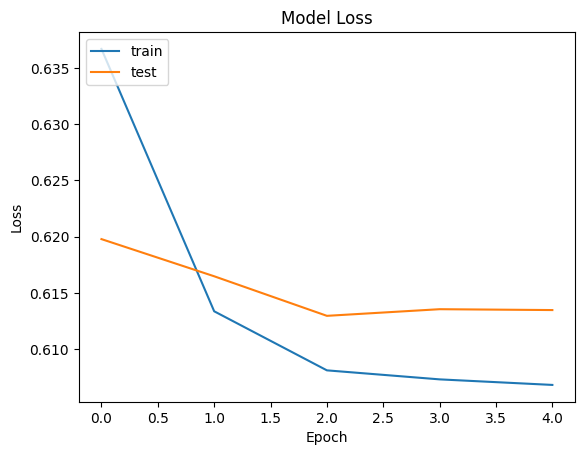

In [17]:
# * Function definition
def plot_model_loss(history):
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")
    plt.show()
    
plot_model_loss(history)


1.4.3. Model evaluation

In [18]:
# Model evaluation: v1  
loss_v1, mse_v1 = model.evaluate(x_val, y_val, verbose=1) 
print(f'Model V1 - Loss: {loss_v1}, MSE: {mse_v1}')  

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6220 - mse: 0.0455
Model V1 - Loss: 0.6220059394836426, MSE: 0.04546782746911049


Comment: We can see from our normalised data that the difference between the prediction and the actual value is 4.5% (MSE).

1.4.4. Model prediction

In [19]:
"""
TO DO:
-> We will now display some recommendations for a user. 
    - Write a function “get_movie_recommendations” with two parameters: user_id and model. 
        * This function will display the 10 highest-rated recommendations for a given user, along with the score and genre of the films. 
    - We will display the 10 films with the highest ratings by the user. We will focus on checking several points:
        * The prediction is made using the encoded ID. However, the display uses the initial ID.
        * Predictions will only be made for films that the user has not seen.
"""

'\nTO DO:\n-> We will now display some recommendations for a user. \n    - Write a function “get_movie_recommendations” with two parameters: user_id and model. \n        * This function will display the 10 highest-rated recommendations for a given user, along with the score and genre of the films. \n    - We will display the 10 films with the highest ratings by the user. We will focus on checking several points:\n        * The prediction is made using the encoded ID. However, the display uses the initial ID.\n        * Predictions will only be made for films that the user has not seen.\n'

In [20]:
def get_movie_recommendations(user_id, model, df=df, movie_df=movie_df, movie2movie_encoded=movie2movie_encoded, movie_encoded2movie=movie_encoded2movie, user2user_encoded=user2user_encoded):  
    # Getting movies already see by user  
    movies_watched_by_user = df[df.userId == user_id]  
      
    # Getting movies that are not yet seen  
    movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]  
    movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))  
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]  
      
    # User Encoder
    user_encoder = user2user_encoded.get(user_id)  
      
    # Forming a table of users and not seen movies  
    user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))  
      
    # Prediction rate for not yet seen movies  
    ratings = model.predict(user_movie_array).flatten()  
      
    # Getting index for 10 best noted  
    top_ratings_indices = ratings.argsort()[-10:][::-1]  
    recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]  
    recommended_movie_ratings = [ratings[x] for x in top_ratings_indices]  
      
    # Display recommendations for user  
    print("Showing recommendations for user: {}".format(user_id))  
    print("====" * 9)  
      
    # Display movies with best rate of user  
    print("Movies with high ratings from user")  
    print("----" * 8)  
    top_movies_user = movies_watched_by_user.sort_values(by="rating", ascending=False).head(10).movieId.values  
    movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]  
    for row in movie_df_rows.itertuples():  
        print(row.title, ":", row.genres)  
      
    print("----" * 8)  
    print("Top 10 movie recommendations")  
    print("----" * 8)  
      
    # Display movies recommended with predicted ratings  
    recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]  
    for row, rating in zip(recommended_movies.itertuples(), recommended_movie_ratings):  
        print(row.title, ":", row.genres, "- Predicted rating:", rating*5)  
        
get_movie_recommendations(user_id=121, model=model) 


303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Showing recommendations for user: 121
Movies with high ratings from user
--------------------------------
Heat (1995) : Action|Crime|Thriller
American President, The (1995) : Comedy|Drama|Romance
Casino (1995) : Crime|Drama
Mr. Holland's Opus (1995) : Drama
Braveheart (1995) : Action|Drama|War
Desperado (1995) : Action|Romance|Western
Shawshank Redemption, The (1994) : Crime|Drama
Forrest Gump (1994) : Comedy|Drama|Romance|War
Dave (1993) : Comedy|Romance
Dances with Wolves (1990) : Adventure|Drama|Western
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller - Predicted rating: 3.455882
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War - Predicted rating: 3.4092643
Godfather: Part II, The (1974) : Crime|Drama - Predicted rating: 3.381359
Amadeus (1984) : Drama - Predicted rating: 3.3649576
Gattaca (1997) : Drama|Sc

Part 2: Adding Multilayer Perceptron to the model 

2.1. Define complexe model

In [21]:
"""
Note
We will now make the previous model more complex by adding dense neuron layers at the output in order to increase the model's complexity 
    and enable it to learn non-linear relationships.

TO DO
    - Define a new class called DenseRecommenderNet that has the same structure as RecommenderNet. 
    - At the output of the embedding multiplication, add three dense layers with 128 neurons, 64 neurons, and 32 neurons. 
    - Each layer is followed by a dropout layer (rate of 20%) to prevent overfitting.
"""

"\nNote\nWe will now make the previous model more complex by adding dense neuron layers at the output in order to increase the model's complexity \n    and enable it to learn non-linear relationships.\n\nTO DO\n    - Define a new class called DenseRecommenderNet that has the same structure as RecommenderNet. \n    - At the output of the embedding multiplication, add three dense layers with 128 neurons, 64 neurons, and 32 neurons. \n    - Each layer is followed by a dropout layer (rate of 20%) to prevent overfitting.\n"

2.1.1. Model 2

In [22]:
# Dense recommendation model
class DenseRecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size,  dense_units=[128,64, 32],dropout_rate=0.2,**kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.dense_units = dense_units
        
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)


        # Define dense layers  
        self.dense_layers = []  
        for units in dense_units:  
            self.dense_layers.append(layers.Dense(units, activation='relu'))
            self.dense_layers.append(layers.Dropout(dropout_rate)) 
            
        self.output_layer = layers.Dense(1, activation='sigmoid')  

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
 

        for dense_layer in self.dense_layers:  
            x = dense_layer(x)

        x = self.output_layer(x) 

        return x

2.1.2 Complexe model training

In [23]:
# * Model compilation
model2 = DenseRecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model2.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['mse'])

In [24]:
# * Model training
history2 = model2.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6428 - mse: 0.0570 - val_loss: 0.6365 - val_mse: 0.0522
Epoch 2/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6296 - mse: 0.0508 - val_loss: 0.6298 - val_mse: 0.0492
Epoch 3/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.6236 - mse: 0.0481 - val_loss: 0.6261 - val_mse: 0.0475
Epoch 4/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.6211 - mse: 0.0470 - val_loss: 0.6221 - val_mse: 0.0458
Epoch 5/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.6180 - mse: 0.0457 - val_loss: 0.6200 - val_mse: 0.0448
Epoch 6/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.6158 - mse: 0.0447 - val_loss: 0.6181 - val_mse: 0.0440
Epoch 7/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.6134 - mse: 0.0437 - val_loss: 0.6177 - val_mse: 0.0439
Epoch 8/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.6112 - mse: 0.0427 - val_loss: 0.6160 - val_mse: 0.0431
Epoch 9/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 8s 11m

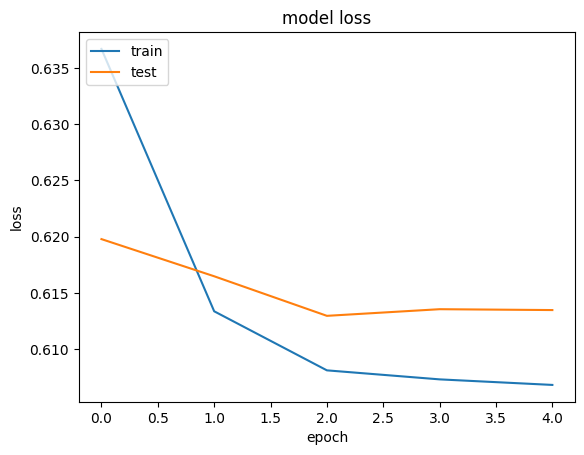

In [25]:
# * Display model loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

2.1.3. Model evatuation

In [26]:
# Evaluating model2 
loss_v2, mse_v2 = model2.evaluate(x_val, y_val, verbose=1) 
print(f'Model V2 - Loss: {loss_v1}, MSE: {mse_v2}')  

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6041 - mse: 0.0380
Model V2 - Loss: 0.6220059394836426, MSE: 0.03799419850111008


2.1.4. Model2 prediction

In [27]:
get_movie_recommendations(user_id=121, model=model2) 

303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Showing recommendations for user: 121
Movies with high ratings from user
--------------------------------
Heat (1995) : Action|Crime|Thriller
American President, The (1995) : Comedy|Drama|Romance
Casino (1995) : Crime|Drama
Mr. Holland's Opus (1995) : Drama
Braveheart (1995) : Action|Drama|War
Desperado (1995) : Action|Romance|Western
Shawshank Redemption, The (1994) : Crime|Drama
Forrest Gump (1994) : Comedy|Drama|Romance|War
Dave (1993) : Comedy|Romance
Dances with Wolves (1990) : Adventure|Drama|Western
--------------------------------
Top 10 movie recommendations
--------------------------------
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi - Predicted rating: 4.0591545
Silence of the Lambs, The (1991) : Crime|Horror|Thriller - Predicted rating: 4.047409
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War - Predicted rating: 3.973723
Godfather, The (1972) : Crime|Drama - Predicted ra